In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
## define a function for the generator:
def make_generator_network(
        num_hidden_layers=1,
        num_hidden_units=100,
        num_output_units=784):
    model = tf.keras.Sequential()
    for i in range(num_hidden_layers):
        model.add(
            tf.keras.layers.Dense(
                units=num_hidden_units, 
                use_bias=False)
            )
        model.add(tf.keras.layers.LeakyReLU())
        
    model.add(tf.keras.layers.Dense(
        units=num_output_units, activation='tanh'))
    return model

## define a function for the discriminator:
def make_discriminator_network(
        num_hidden_layers=1,
        num_hidden_units=100,
        num_output_units=1):
    model = tf.keras.Sequential()
    for i in range(num_hidden_layers):
        model.add(tf.keras.layers.Dense(units=num_hidden_units))
        model.add(tf.keras.layers.LeakyReLU())
        model.add(tf.keras.layers.Dropout(rate=0.5))
        
    model.add(
        tf.keras.layers.Dense(
            units=num_output_units, 
            activation=None)
        )
    return model

In [3]:
image_size = (28, 28)
z_size = 20
mode_z = 'uniform'  # 'uniform' vs. 'normal'
gen_hidden_layers = 1
gen_hidden_size = 100
disc_hidden_layers = 1
disc_hidden_size = 100

tf.random.set_seed(1)

gen_model = make_generator_network(
    num_hidden_layers=gen_hidden_layers, 
    num_hidden_units=gen_hidden_size,
    num_output_units=np.prod(image_size))

gen_model.build(input_shape=(None, z_size))
gen_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               2000      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 784)               79184     
Total params: 81,184
Trainable params: 81,184
Non-trainable params: 0
_________________________________________________________________


In [4]:
disc_model = make_discriminator_network(
    num_hidden_layers=disc_hidden_layers,
    num_hidden_units=disc_hidden_size)

disc_model.build(input_shape=(None, np.prod(image_size)))
disc_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 100)               78500     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 100)               0         
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
Total params: 78,601
Trainable params: 78,601
Non-trainable params: 0
_________________________________________________________________


In [5]:
mnist_bldr = tfds.builder('mnist')
mnist_bldr.download_and_prepare()
mnist = mnist_bldr.as_dataset(shuffle_files=False)

def preprocess(ex, mode='uniform'):
    image = ex['image']
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.reshape(image, [-1])
    image = image*2 - 1.0
    if mode == 'uniform':
        input_z = tf.random.uniform(
            shape=(z_size,), minval=-1.0, maxval=1.0)
    elif mode == 'normal':
        input_z = tf.random.normal(shape=(z_size,))
    return input_z, image



mnist_trainset = mnist['train']

print('Before preprocessing:  ')
example = next(iter(mnist_trainset))['image']
print('dtype: ', example.dtype, ' Min: {} Max: {}'.format(np.min(example), np.max(example)))

mnist_trainset = mnist_trainset.map(preprocess)

print('After preprocessing:  ')
example = next(iter(mnist_trainset))[0]
print('dtype: ', example.dtype, ' Min: {} Max: {}'.format(np.min(example), np.max(example)))

Before preprocessing:  
dtype:  <dtype: 'uint8'>  Min: 0 Max: 255
After preprocessing:  
dtype:  <dtype: 'float32'>  Min: -0.8737728595733643 Max: 0.9460210800170898


In [6]:
mnist_trainset = mnist_trainset.batch(32, drop_remainder=True)
input_z, input_real = next(iter(mnist_trainset))
print('input-z -- shape:', input_z.shape)
print('input-real -- shape:', input_real.shape)

g_output = gen_model(input_z)
print('Output of G -- shape:', g_output.shape)

d_logits_real = disc_model(input_real)
d_logits_fake = disc_model(g_output)
print('Disc. (real) -- shape:', d_logits_real.shape)
print('Disc. (fake) -- shape:', d_logits_fake.shape)

input-z -- shape: (32, 20)
input-real -- shape: (32, 784)
Output of G -- shape: (32, 784)
Disc. (real) -- shape: (32, 1)
Disc. (fake) -- shape: (32, 1)


In [7]:
loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)

## Loss for the Generator
g_labels_real = tf.ones_like(d_logits_fake)
g_loss = loss_fn(y_true=g_labels_real, y_pred=d_logits_fake)
print('Generator Loss: {:.4f}'.format(g_loss))

## Loss for the Discriminator
d_labels_real = tf.ones_like(d_logits_real)
d_labels_fake = tf.zeros_like(d_logits_fake)

d_loss_real = loss_fn(y_true=d_labels_real, y_pred=d_logits_real)
d_loss_fake = loss_fn(y_true=d_labels_fake, y_pred=d_logits_fake)
print('Discriminator Losses: Real {:.4f} Fake {:.4f}'
      .format(d_loss_real.numpy(), d_loss_fake.numpy()))

Generator Loss: 0.7355
Discriminator Losses: Real 1.5073 Fake 0.6583


In [9]:
import time


num_epochs = 100
batch_size = 64
image_size = (28, 28)
z_size = 20
mode_z = 'uniform'
gen_hidden_layers = 1
gen_hidden_size = 100
disc_hidden_layers = 1
disc_hidden_size = 100

tf.random.set_seed(1)
np.random.seed(1)


if mode_z == 'uniform':
    fixed_z = tf.random.uniform(
        shape=(batch_size, z_size),
        minval=-1, maxval=1)
elif mode_z == 'normal':
    fixed_z = tf.random.normal(
        shape=(batch_size, z_size))


def create_samples(g_model, input_z):
    g_output = g_model(input_z, training=False)
    images = tf.reshape(g_output, (batch_size, *image_size))    
    return (images+1)/2.0

## Set-up the dataset
mnist_trainset = mnist['train']
mnist_trainset = mnist_trainset.map(
    lambda ex: preprocess(ex, mode=mode_z))

mnist_trainset = mnist_trainset.shuffle(10000)
mnist_trainset = mnist_trainset.batch(
    batch_size, drop_remainder=True)

## Set-up the model
#with tf.device(device_name):
gen_model = make_generator_network(
    num_hidden_layers=gen_hidden_layers, 
    num_hidden_units=gen_hidden_size,
    num_output_units=np.prod(image_size))
gen_model.build(input_shape=(None, z_size))

disc_model = make_discriminator_network(
    num_hidden_layers=disc_hidden_layers,
    num_hidden_units=disc_hidden_size)
disc_model.build(input_shape=(None, np.prod(image_size)))

## Loss function and optimizers:
loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)
g_optimizer = tf.keras.optimizers.Adam()
d_optimizer = tf.keras.optimizers.Adam()

all_losses = []
all_d_vals = []
epoch_samples = []

start_time = time.time()
for epoch in range(1, num_epochs+1):
    epoch_losses, epoch_d_vals = [], []
    for i,(input_z,input_real) in enumerate(mnist_trainset):
        
        ## Compute generator's loss
        with tf.GradientTape() as g_tape:
            g_output = gen_model(input_z)
            d_logits_fake = disc_model(g_output, training=True)
            labels_real = tf.ones_like(d_logits_fake)
            g_loss = loss_fn(y_true=labels_real, y_pred=d_logits_fake)
            
        g_grads = g_tape.gradient(g_loss, gen_model.trainable_variables)
        g_optimizer.apply_gradients(
            grads_and_vars=zip(g_grads, gen_model.trainable_variables))

        ## Compute discriminator's loss
        with tf.GradientTape() as d_tape:
            d_logits_real = disc_model(input_real, training=True)

            d_labels_real = tf.ones_like(d_logits_real)
            
            d_loss_real = loss_fn(
                y_true=d_labels_real, y_pred=d_logits_real)

            d_logits_fake = disc_model(g_output, training=True)
            d_labels_fake = tf.zeros_like(d_logits_fake)

            d_loss_fake = loss_fn(
                y_true=d_labels_fake, y_pred=d_logits_fake)

            d_loss = d_loss_real + d_loss_fake

        ## Compute the gradients of d_loss
        d_grads = d_tape.gradient(d_loss, disc_model.trainable_variables)
        
        ## Optimization: Apply the gradients
        d_optimizer.apply_gradients(
            grads_and_vars=zip(d_grads, disc_model.trainable_variables))
                           
        epoch_losses.append(
            (g_loss.numpy(), d_loss.numpy(), 
             d_loss_real.numpy(), d_loss_fake.numpy()))
        
        d_probs_real = tf.reduce_mean(tf.sigmoid(d_logits_real))
        d_probs_fake = tf.reduce_mean(tf.sigmoid(d_logits_fake))
        epoch_d_vals.append((d_probs_real.numpy(), d_probs_fake.numpy()))        
    all_losses.append(epoch_losses)
    all_d_vals.append(epoch_d_vals)
    print(
        'Epoch {:03d} | ET {:.2f} min | Avg Losses >>'
        ' G/D {:.4f}/{:.4f} [D-Real: {:.4f} D-Fake: {:.4f}]'
        .format(
            epoch, (time.time() - start_time)/60, 
            *list(np.mean(all_losses[-1], axis=0))))
    epoch_samples.append(
        create_samples(gen_model, fixed_z).numpy())

Epoch 001 | ET 0.59 min | Avg Losses >> G/D 2.8680/0.2890 [D-Real: 0.0333 D-Fake: 0.2557]
Epoch 002 | ET 1.34 min | Avg Losses >> G/D 5.1422/0.3252 [D-Real: 0.1036 D-Fake: 0.2216]
Epoch 003 | ET 2.09 min | Avg Losses >> G/D 3.3506/0.6922 [D-Real: 0.3104 D-Fake: 0.3818]
Epoch 004 | ET 3.12 min | Avg Losses >> G/D 2.0684/0.8533 [D-Real: 0.4475 D-Fake: 0.4059]
Epoch 005 | ET 4.06 min | Avg Losses >> G/D 2.2654/0.7769 [D-Real: 0.4218 D-Fake: 0.3550]
Epoch 006 | ET 4.95 min | Avg Losses >> G/D 1.5752/1.0051 [D-Real: 0.5366 D-Fake: 0.4686]
Epoch 007 | ET 5.82 min | Avg Losses >> G/D 1.6587/0.9397 [D-Real: 0.5083 D-Fake: 0.4314]
Epoch 008 | ET 6.43 min | Avg Losses >> G/D 1.4705/1.0419 [D-Real: 0.5574 D-Fake: 0.4846]
Epoch 009 | ET 7.28 min | Avg Losses >> G/D 1.5553/0.9616 [D-Real: 0.5267 D-Fake: 0.4348]
Epoch 010 | ET 8.11 min | Avg Losses >> G/D 1.4250/1.0229 [D-Real: 0.5564 D-Fake: 0.4665]
Epoch 011 | ET 8.93 min | Avg Losses >> G/D 1.4027/1.0438 [D-Real: 0.5594 D-Fake: 0.4844]
Epoch 012 

Epoch 092 | ET 74.84 min | Avg Losses >> G/D 0.9664/1.3056 [D-Real: 0.6530 D-Fake: 0.6526]
Epoch 093 | ET 75.60 min | Avg Losses >> G/D 0.9050/1.3254 [D-Real: 0.6657 D-Fake: 0.6596]
Epoch 094 | ET 76.35 min | Avg Losses >> G/D 0.8860/1.3245 [D-Real: 0.6648 D-Fake: 0.6597]
Epoch 095 | ET 77.11 min | Avg Losses >> G/D 0.9219/1.3237 [D-Real: 0.6645 D-Fake: 0.6592]
Epoch 096 | ET 77.87 min | Avg Losses >> G/D 0.9167/1.3181 [D-Real: 0.6629 D-Fake: 0.6552]
Epoch 097 | ET 78.61 min | Avg Losses >> G/D 0.8915/1.3193 [D-Real: 0.6627 D-Fake: 0.6566]
Epoch 098 | ET 79.36 min | Avg Losses >> G/D 0.9108/1.3225 [D-Real: 0.6621 D-Fake: 0.6604]
Epoch 099 | ET 80.12 min | Avg Losses >> G/D 0.9080/1.3225 [D-Real: 0.6638 D-Fake: 0.6587]
Epoch 100 | ET 80.86 min | Avg Losses >> G/D 0.8989/1.3256 [D-Real: 0.6631 D-Fake: 0.6625]


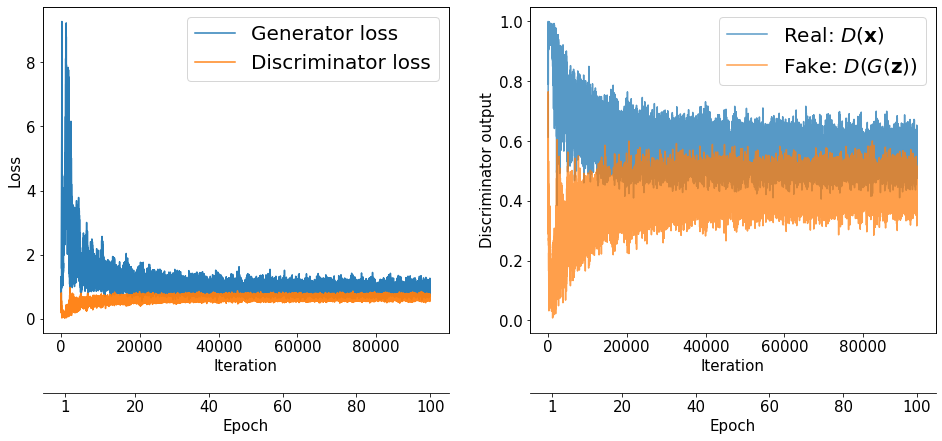

In [10]:
import itertools


fig = plt.figure(figsize=(16, 6))

## Plotting the losses
ax = fig.add_subplot(1, 2, 1)
g_losses = [item[0] for item in itertools.chain(*all_losses)]
d_losses = [item[1]/2.0 for item in itertools.chain(*all_losses)]
plt.plot(g_losses, label='Generator loss', alpha=0.95)
plt.plot(d_losses, label='Discriminator loss', alpha=0.95)
plt.legend(fontsize=20)
ax.set_xlabel('Iteration', size=15)
ax.set_ylabel('Loss', size=15)

epochs = np.arange(1, 101)
epoch2iter = lambda e: e*len(all_losses[-1])
epoch_ticks = [1, 20, 40, 60, 80, 100]
newpos = [epoch2iter(e) for e in epoch_ticks]
ax2 = ax.twiny()
ax2.set_xticks(newpos)
ax2.set_xticklabels(epoch_ticks)
ax2.xaxis.set_ticks_position('bottom')
ax2.xaxis.set_label_position('bottom')
ax2.spines['bottom'].set_position(('outward', 60))
ax2.set_xlabel('Epoch', size=15)
ax2.set_xlim(ax.get_xlim())
ax.tick_params(axis='both', which='major', labelsize=15)
ax2.tick_params(axis='both', which='major', labelsize=15)

## Plotting the outputs of the discriminator
ax = fig.add_subplot(1, 2, 2)
d_vals_real = [item[0] for item in itertools.chain(*all_d_vals)]
d_vals_fake = [item[1] for item in itertools.chain(*all_d_vals)]
plt.plot(d_vals_real, alpha=0.75, label=r'Real: $D(\mathbf{x})$')
plt.plot(d_vals_fake, alpha=0.75, label=r'Fake: $D(G(\mathbf{z}))$')
plt.legend(fontsize=20)
ax.set_xlabel('Iteration', size=15)
ax.set_ylabel('Discriminator output', size=15)

ax2 = ax.twiny()
ax2.set_xticks(newpos)
ax2.set_xticklabels(epoch_ticks)
ax2.xaxis.set_ticks_position('bottom')
ax2.xaxis.set_label_position('bottom')
ax2.spines['bottom'].set_position(('outward', 60))
ax2.set_xlabel('Epoch', size=15)
ax2.set_xlim(ax.get_xlim())
ax.tick_params(axis='both', which='major', labelsize=15)
ax2.tick_params(axis='both', which='major', labelsize=15)


#plt.savefig('images/ch17-gan-learning-curve.pdf')
plt.show()

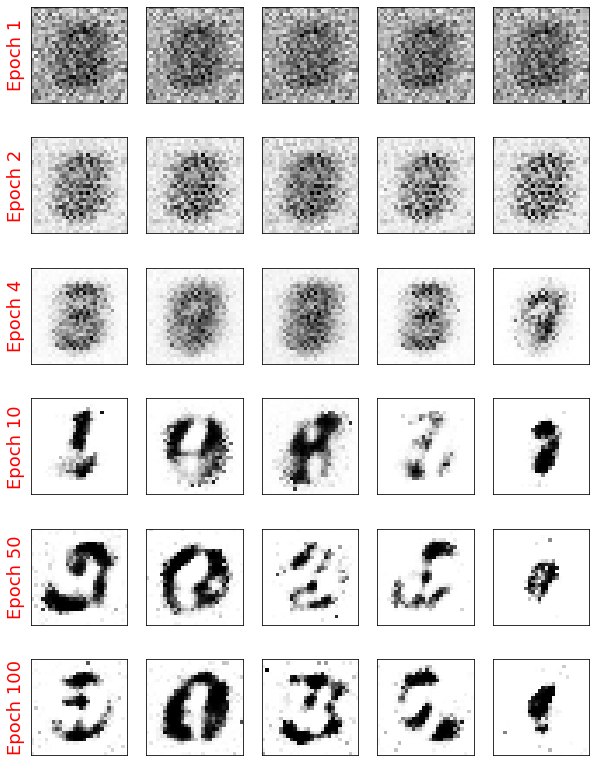

In [11]:
selected_epochs = [1, 2, 4, 10, 50, 100]
fig = plt.figure(figsize=(10, 14))
for i,e in enumerate(selected_epochs):
    for j in range(5):
        ax = fig.add_subplot(6, 5, i*5+j+1)
        ax.set_xticks([])
        ax.set_yticks([])
        if j == 0:
            ax.text(
                -0.06, 0.5, 'Epoch {}'.format(e),
                rotation=90, size=18, color='red',
                horizontalalignment='right',
                verticalalignment='center', 
                transform=ax.transAxes)
        
        image = epoch_samples[e-1][j]
        ax.imshow(image, cmap='gray_r')
    
#plt.savefig('images/ch17-vanila-gan-samples.pdf')
plt.show()